### Given the scarcity of data in this task, we will use k-Fold cross-validation for training with k set to a large value to make a good use of the available data of a significantly small size.

#### Following are the hyperparameters that can be tuned for a neural network

1. learning rate
2. no of hidden units
3. no of epochs to train
4. dropout probability
5. loss function (NOT TUNED HERE)
6. mini batch size
7. weights initialization (NOT TUNED HERE)
8. l1/ l2 regularizers
9. activation function to use at the nodes (NOT TUNED HERE)
10. no of layers (NOT TUNED HERE)
11. learning rate decay (NOT TUNED HERE)
12. optimizer (NOT TUNED HERE)
13. momentum (only if sgd or rmsprop optimizer used, not with adam, adagrad)
14. momentum_dampening (only if sgd or rmsprop optimizer used, not with adam, adagrad) (NOT TUNED HERE)


There are several methods to tune hyperparameters of a neural network. Two of them are grid search and randomized search that select points in the parameter space and evaluate these points (each point is essestially a unique configuration of hyperparameters in the hyperparameter space) and return the best hyperparameter combination based on the performace on the validation data.

#### How is grid search/ randomized search done with k-fold cross validation?
1. Select n points in the hyperparameter space. For each point, do:
    a. Each point corresponds to a hyperparameter configuration in the hyperparameter space.
    b. Train and evaluate this model k times as follows.
        i. Randomly divide the training data into k partitions. Call them partition 1, partition 2,.........., partition k.
        ii. Repeat for each partition j starting from j = 1 to j = k
            . Train the model with this hyperparameter configuration on the partitions except partition j and test on                     partition j.
            . Store the performance of the model.
        iii. Calculate the average performance of the model with this hyperparameter configuration over the k folds.
2. Declare the model that was trained using the hyperparameters corresponding to the point that achieved the best              validation result as the best model and declare this choice of hyperparameters as the best hyperparameters.
3. Predict the labels of the testing data using this model.

## Import Libraries

In [2]:
import time
import copy
import sys
import os
import random
import csv
from math import sqrt


import numpy as np

import pandas as pd

import seaborn as sns


import sklearn
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from skorch import NeuralNetRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate


from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from joblib import dump, load

In [3]:
print("The python version used is {}".format(sys.version))
print("The torch version used is {}".format(torch.__version__))
print("The sklearn version used is {}".format(sklearn.__version__))

The python version used is 3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)]
The torch version used is 1.4.0
The sklearn version used is 0.20.3


## Import Data

In [4]:
training_data = pd.read_csv("normalized_training_features_and_targets.csv", sep = ",")
training_data.head()

,% of Cr,% of Hf,% of Mo,% of Nb,% of Ta,% of Ti,% of V,% of Zr,% of Ni,% of Al,% of Mn,%Cu,%C,Entropy,Hardness
0,0.0,0.0,0.0000,0.470,0.44,0.97491,0.0000,0.992366,0.000000,0.138686,0.0,0.0,0.0,0.602527,0.429768
1,0.0,0.0,0.7500,0.200,0.25,0.00000,0.4000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.589731,0.539457
2,0.0,0.0,0.5815,0.000,0.00,0.00000,0.4026,0.000000,0.396171,0.000000,0.0,0.0,0.0,0.733380,0.559966
3,0.0,0.0,0.5000,0.800,0.25,0.00000,0.4000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.541151,0.351534
4,0.0,0.0,0.0000,0.468,0.33,0.97491,0.0860,1.000000,0.000000,0.138686,0.0,0.0,0.0,0.741308,0.441290


In [5]:
num_features = len( training_data.iloc[0,:] ) - 1
print("The number of features is {}".format(num_features))
X_training = training_data.iloc[:,0:num_features]

X_training.head()

The number of features is 14


,% of Cr,% of Hf,% of Mo,% of Nb,% of Ta,% of Ti,% of V,% of Zr,% of Ni,% of Al,% of Mn,%Cu,%C,Entropy
0,0.0,0.0,0.0000,0.470,0.44,0.97491,0.0000,0.992366,0.000000,0.138686,0.0,0.0,0.0,0.602527
1,0.0,0.0,0.7500,0.200,0.25,0.00000,0.4000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.589731
2,0.0,0.0,0.5815,0.000,0.00,0.00000,0.4026,0.000000,0.396171,0.000000,0.0,0.0,0.0,0.733380
3,0.0,0.0,0.5000,0.800,0.25,0.00000,0.4000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.541151
4,0.0,0.0,0.0000,0.468,0.33,0.97491,0.0860,1.000000,0.000000,0.138686,0.0,0.0,0.0,0.741308


In [6]:
Y_training = pd.DataFrame(training_data["Hardness"])
Y_training.head()

,Hardness
0,0.429768
1,0.539457
2,0.559966
3,0.351534
4,0.441290


## Initialize Seeds for Reproducibility

In [7]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

device_to_use = "cuda" if torch.cuda.device_count() > 0 else "cpu"

## torch Regression Model definition

In [8]:
class Regression_Module(nn.Module):
    def __init__(self, num_units = 10, dropout = 0.5, activation = F.leaky_relu, input_dim = num_features, output_dim = 1):
           
        
        super(Regression_Module, self).__init__()
        self.activation = activation
        
        
        self.L1 = nn.Linear(input_dim, num_units)
        self.L2 = nn.Linear(num_units, num_units)
        
        #self.batchnorm_1 = nn.BatchNorm1d(num_units, 1e-12, affine=True, track_running_stats=True)
        self.dropout_1 = nn.Dropout(p=dropout)
        
        self.L3 = nn.Linear(num_units, num_units)
        self.L4 = nn.Linear(num_units, num_units)
        
        #self.batchnorm_2 = nn.BatchNorm1d(num_units, 1e-12, affine=True, track_running_stats=True)
        self.dropout_2 = nn.Dropout(p=dropout)
        
        self.L5 = nn.Linear(num_units, num_units)
        self.L6 = nn.Linear(num_units, output_dim)



    def forward(self, input):
            
        input = self.activation(self.L1(input.float()))
        input = self.L2(input.float())

        # input = input.unsqueeze(0) #https://discuss.pytorch.org/t/batchnorm1d-valueerror-expected-2d-or-3d-input-got-1d-input/42081
        # input = self.batchnorm_1(input)

        input = self.activation(input.float())
        input = self.dropout_1(input.float())

        input = self.activation(self.L3(input.float()))
        input = self.L4(input.float())

        # input = input.unsqueeze(0)
        # input = self.batchnorm_2(input)

        input = self.activation(input.float())
        input = self.dropout_2(input.float())

        input = self.activation(self.L5(input.float()))

        input = self.L6(input.float())


        #VVI: need to return in double format instead of a float
        return input.double()

## skorch Regression Model definition
Takes torch regressor as an argument.

In [9]:
skorch_regressor = NeuralNetRegressor(module = Regression_Module,  #pass a torch module class
                                      device = device_to_use,
                                      iterator_train__shuffle = True,
                                      
                                     ) 
                                      

## Generate hyperparameters for hyperparameter tuning using sklearn's Randomized Search


In [10]:
#lr = np.random.uniform(low = 0.000001,high = 0.05, size = 20).tolist()
lr = [0.00005, 0.0001, 0.0003, 0.0005, 0.001, 0.003, 0.005]

weight_decay_for_regularization = [1e-5, 5e-5, 1e-4, 5e-5, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]      #weight decay equals L2 regularization for SGD

momentum_vals = [0.5, 0.75, 0.99]

momentum_dampening = [0.]

nesterov = [True, False]

no_of_nodes_per_layer = [num_features, int(num_features * 1.25), int(num_features * 1.5), int(num_features * 1.75), int(num_features *2), int(num_features * 2.5)]

#max_epochs = [epoch_num for epoch_num in range(25, 400, 25)]
max_epochs = [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400]

dropout_probability_per_node = [0., 0.3, 0.5]

#We will use onle mse as the loss function for now. so skip tuning the loss function.

minibatch_size = [1, 2, 4, 8, 16, 32, 64] #should always be less than the size of the trianing set

#optimizers = [torch.optim.SGD, torch.optim.RMSprop, torch.optim.Adagrad]
optimizers = [torch.optim.SGD] #Using only SGD

### Manually generate a list of random points in the hyperparameter space

In [43]:
hyperparam_space_list = [lr,weight_decay_for_regularization, momentum_vals, momentum_dampening, nesterov, 
                        no_of_nodes_per_layer, max_epochs, dropout_probability_per_node, minibatch_size, optimizers]

random_hyperparameter_configurations = []

no_of_hyperparam_configs = 2
no_of_cv_folds = 2

for idx in range(no_of_hyperparam_configs):
    configuration = []
        
    for idx in range(len(hyperparam_space_list)):
        configuration.append(random.choice(hyperparam_space_list[idx]))

    random_hyperparameter_configurations.append(configuration)

    configuration = []

# Print and save the random hyperparameters' configurations
for idx in range(no_of_hyperparam_configs):
    print(random_hyperparameter_configurations[idx])

#random_hyperparam_configs = np.savetxt("random_hyperparam_configs.csv", np.array(random_hyperparameter_configurations), delimiter = ",")

column_names = ["lr", "weight_decay_for_regularization", "momentum_vals", "momentum_dampening", "nesterov", "no_of_nodes_per_layer", 
                "max_epochs", "dropout_probability_per_node", "minibatch_size", "optimizers"]
with open('random_hyperparam_configs', 'w') as f: 

    write = csv.writer(f) 
    write.writerow(column_names) 
    write.writerows(random_hyperparameter_configurations)            
    

[5e-05, 0.0001, 0.99, 0.0, False, 21, 350, 0.0, 32, <class 'torch.optim.sgd.SGD'>]
[0.003, 5e-05, 0.75, 0.0, True, 17, 100, 0.5, 16, <class 'torch.optim.sgd.SGD'>]


#### Run a for loop for each of the hyperparameter configuration generated above


In [57]:
individual_cv_estimators_for_all_splits = []
mse_on_each_validation_split = []
average_mse_on_validation_list = []

total_unique_estimators =  no_of_hyperparam_configs * no_of_cv_folds
estimators_counter = 0

for idx in range(len(random_hyperparameter_configurations)):
    
    net = NeuralNetRegressor(       module=Regression_Module,
                        
                                    optimizer__lr = random_hyperparameter_configurations[idx][0],
                                    optimizer__weight_decay = random_hyperparameter_configurations[idx][1],
                                    optimizer__momentum = random_hyperparameter_configurations[idx][2],
                                    optimizer__dampening = random_hyperparameter_configurations[idx][3],
                                    optimizer__nesterov = random_hyperparameter_configurations[idx][4],
                                    module__num_units = random_hyperparameter_configurations[idx][5],
                                    max_epochs = random_hyperparameter_configurations[idx][6],
                                    module__dropout = random_hyperparameter_configurations[idx][7],
                                    iterator_train__batch_size = random_hyperparameter_configurations[idx][8],
                                    optimizer = random_hyperparameter_configurations[idx][9],

                                    )
    
    scores = cross_validate( estimator = net,
                             X = X_training.values,
                             y = Y_training.values,
                             scoring='neg_mean_squared_error',
                             cv = 2,
                             return_estimator = True,
                             verbose = 0)
    
    
    # Store each split's estimator from cross-validation
    individual_cv_estimators_for_all_splits.append(scores["estimator"])
    
    dict_of_params = scores["estimator"][0].get_params()
    
    
    print("\n")
    for param in dict_of_params:
        
        print(param + " : " + str(dict_of_params[param]))
    print("\n")
    
    
    
    
    # Save uncertainty among different folds for the same estimator
    mse_on_each_validation_split.append(scores["test_score"])
    
    # Salve also the average validatoin set MSE for this hyperparam config
    avg_mse = (-1 * scores["test_score"].mean()) # using -1 because the scoring is the negative of mse
    average_mse_on_validation_list.append(avg_mse)
    
    
    
    # Save the current estimator parameters
    for idx in range(len(scores["estimator"])):
        
        dump(scores["estimator"][idx],"../Saved_Models/NN_model_hyperparam_config_"+ str(estimators_counter)+".joblib")
    

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.2886        0.2336  0.0040
      2        0.2884        0.2332  0.0050
      3        0.2878        0.2325  0.0040
      4        0.2870        0.2315  0.0040
      5        0.2859        0.2303  0.0040
      6        0.2846        0.2289  0.0050
      7        0.2830        0.2273  0.0040
      8        0.2811        0.2255  0.0049
      9        0.2791        0.2234  0.0050
     10        0.2768        0.2212  0.0040
     11        0.2743        0.2188  0.0040
     12        0.2715        0.2162  0.0040
     13        0.2686        0.2134  0.0050
     14        0.2655        0.2105  0.0040
     15        0.2622        0.2074  0.0050
     16        0.2588        0.2042  0.0050
     17        0.2552        0.2009  0.0040
     18        0.2514        0.1974  0.0040
     19        0.2475        0.1938  0.0050
     20        0.2435        0.1902  0.0040
     21        0.2393        0.1

    152        0.0588        0.0619  0.0040
    153        0.0585        0.0614  0.0040
    154        0.0582        0.0609  0.0040
    155        0.0578        0.0604  0.0040
    156        0.0575        0.0599  0.0040
    157        0.0571        0.0594  0.0040
    158        0.0568        0.0589  0.0050
    159        0.0564        0.0584  0.0050
    160        0.0561        0.0578  0.0050
    161        0.0557        0.0573  0.0043
    162        0.0554        0.0568  0.0040
    163        0.0550        0.0562  0.0040
    164        0.0547        0.0557  0.0050
    165        0.0544        0.0552  0.0050
    166        0.0540        0.0547  0.0050
    167        0.0537        0.0541  0.0050
    168        0.0534        0.0536  0.0040
    169        0.0530        0.0531  0.0040
    170        0.0527        0.0526  0.0040
    171        0.0524        0.0520  0.0050
    172        0.0521        0.0515  0.0040
    173        0.0518        0.0510  0.0050
    174        0.0515        0.0

    338        0.0468        0.0391  0.0040
    339        0.0468        0.0392  0.0040
    340        0.0468        0.0392  0.0040
    341        0.0468        0.0392  0.0050
    342        0.0468        0.0393  0.0040
    343        0.0468        0.0393  0.0040
    344        0.0468        0.0393  0.0050
    345        0.0468        0.0394  0.0040
    346        0.0468        0.0394  0.0040
    347        0.0468        0.0395  0.0040
    348        0.0468        0.0395  0.0040
    349        0.0468        0.0395  0.0050
    350        0.0468        0.0395  0.0050
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.2245        0.3129  0.0040
      2        0.2243        0.3125  0.0050
      3        0.2239        0.3118  0.0050
      4        0.2234        0.3110  0.0040
      5        0.2227        0.3099  0.0040
      6        0.2218        0.3086  0.0050
      7        0.2207        0.3071  0.0040
      8        0.2195        0.3

    126        0.0612        0.0563  0.0080
    127        0.0614        0.0563  0.0040
    128        0.0616        0.0563  0.0040
    129        0.0618        0.0563  0.0040
    130        0.0620        0.0563  0.0050
    131        0.0621        0.0563  0.0040
    132        0.0623        0.0563  0.0050
    133        0.0624        0.0563  0.0040
    134        0.0625        0.0563  0.0040
    135        0.0626        0.0563  0.0050
    136        0.0627        0.0563  0.0050
    137        0.0628        0.0564  0.0040
    138        0.0628        0.0564  0.0050
    139        0.0629        0.0564  0.0040
    140        0.0629        0.0564  0.0050
    141        0.0629        0.0564  0.0040
    142        0.0629        0.0564  0.0040
    143        0.0629        0.0564  0.0040
    144        0.0629        0.0564  0.0050
    145        0.0628        0.0563  0.0050
    146        0.0628        0.0563  0.0050
    147        0.0627        0.0563  0.0040
    148        0.0626        0.0

    310        0.0530        0.0682  0.0050
    311        0.0530        0.0682  0.0040
    312        0.0530        0.0681  0.0050
    313        0.0529        0.0680  0.0040
    314        0.0529        0.0679  0.0039
    315        0.0529        0.0679  0.0040
    316        0.0529        0.0678  0.0040
    317        0.0529        0.0677  0.0050
    318        0.0529        0.0676  0.0050
    319        0.0529        0.0676  0.0039
    320        0.0529        0.0675  0.0040
    321        0.0529        0.0674  0.0050
    322        0.0528        0.0673  0.0040
    323        0.0528        0.0672  0.0039
    324        0.0528        0.0672  0.0040
    325        0.0528        0.0671  0.0050
    326        0.0528        0.0670  0.0040
    327        0.0528        0.0669  0.0039
    328        0.0528        0.0669  0.0040
    329        0.0528        0.0668  0.0050
    330        0.0528        0.0667  0.0040
    331        0.0528        0.0666  0.0050
    332        0.0528        0.0

c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


     12        0.0920        0.0591  0.0060
     13        0.0815        0.0538  0.0060
     14        0.0770        0.0496  0.0050
     15        0.0703        0.0464  0.0069
     16        0.0675        0.0440  0.0069
     17        0.0605        0.0421  0.0060
     18        0.0604        0.0407  0.0070
     19        0.0574        0.0396  0.0060
     20        0.0551        0.0389  0.0060
     21        0.0544        0.0383  0.0050
     22        0.0506        0.0379  0.0060
     23        0.0523        0.0377  0.0060
     24        0.0543        0.0376  0.0060
     25        0.0502        0.0375  0.0060
     26        0.0499        0.0375  0.0050
     27        0.0503        0.0375  0.0059
     28        0.0492        0.0376  0.0050
     29        0.0492        0.0377  0.0060
     30        0.0485        0.0378  0.0060
     31        0.0479        0.0379  0.0070
     32        0.0473        0.0380  0.0060
     33        0.0469        0.0381  0.0060
     34        0.0472        0.0

     75        0.0512        0.0645  0.0060
     76        0.0522        0.0645  0.0060
     77        0.0534        0.0645  0.0060
     78        0.0529        0.0645  0.0060
     79        0.0538        0.0645  0.0060
     80        0.0533        0.0645  0.0060
     81        0.0527        0.0645  0.0059
     82        0.0530        0.0645  0.0049
     83        0.0532        0.0645  0.0060
     84        0.0535        0.0645  0.0049
     85        0.0525        0.0644  0.0060
     86        0.0526        0.0644  0.0049
     87        0.0523        0.0644  0.0060
     88        0.0522        0.0644  0.0060
     89        0.0536        0.0644  0.0060
     90        0.0532        0.0644  0.0060
     91        0.0529        0.0645  0.0050
     92        0.0532        0.0645  0.0060
     93        0.0523        0.0645  0.0049
     94        0.0527        0.0645  0.0069
     95        0.0508        0.0645  0.0060
     96        0.0544        0.0645  0.0050
     97        0.0553        0.0

c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Plot variance of average mse on validation data for each hyperparameter configuration

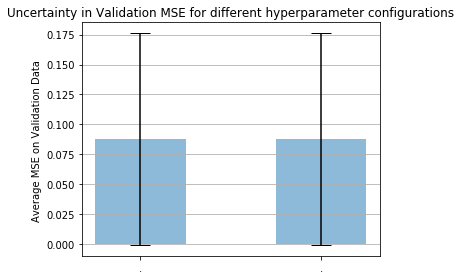

In [38]:
mean_of_average_mse_on_validation_list = np.mean(average_mse_on_validation_list)

std_of_average_mse_on_validation_list = np.std(average_mse_on_validation_list)

# Define individual_agents_name_list, positions, bar heights and list_of_standard_deviations_of_costs_of_all_agents bar heights
individual_agents_name_list = ['.',".",]
x_pos = np.arange(len(individual_agents_name_list))
list_of_mean_of_average_mse_on_validation_list = [mean_of_average_mse_on_validation_list,mean_of_average_mse_on_validation_list]
list_of_std_of_average_mse_on_validation_list = [std_of_average_mse_on_validation_list,std_of_average_mse_on_validation_list]


# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, list_of_mean_of_average_mse_on_validation_list,
       yerr=list_of_std_of_average_mse_on_validation_list,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10,
       width = 0.5, # defines the width of each bar, can pass a list of distince bar widths as well
        )
ax.set_ylabel('Average MSE on Validation Data ')
ax.set_xticks(x_pos)
ax.set_xticklabels(individual_agents_name_list)
ax.set_title('Uncertainty in Validation MSE for different hyperparameter configurations')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('../plots/bar_plot_with_error_bars_for_average_mse.png')
plt.show()

## Train all 350 models on all the training samples

In [ ]:
last_epoch_training_losses = []

for idx in range(len(random_hyperparameter_configurations)):
    
    net = NeuralNetRegressor(       module=Regression_Module,
                        
                                    optimizer__lr = random_hyperparameter_configurations[idx][0],
                                    optimizer__weight_decay = random_hyperparameter_configurations[idx][1],
                                    optimizer__momentum = random_hyperparameter_configurations[idx][2],
                                    optimizer__dampening = random_hyperparameter_configurations[idx][3],
                                    optimizer__nesterov = random_hyperparameter_configurations[idx][4],
                                    module__num_units = random_hyperparameter_configurations[idx][5],
                                    max_epochs = random_hyperparameter_configurations[idx][6],
                                    module__dropout = random_hyperparameter_configurations[idx][7],
                                    iterator_train__batch_size = random_hyperparameter_configurations[idx][8],
                                    optimizer = random_hyperparameter_configurations[idx][9],

                                    )
    net.fit(X = X_training.values, y = Y_training.values,scoring='neg_mean_squared_error',)
    
    net.save_params(f_params="../Saved_Models/nn_model_" + str(idx) + ".pkl")
    # https://skorch.readthedocs.io/en/stable/user/save_load.html



## Plot Uncertainty among different models trained for each test sample

In [58]:
# Predict on test data
testing_data = pd.read_csv("normalized_testing_features_and_targets.csv", sep = ",")
testing_data.head()

,% of Cr,% of Hf,% of Mo,% of Nb,% of Ta,% of Ti,% of V,% of Zr,% of Ni,% of Al,% of Mn,%Cu,%C,Entropy,Hardness
0,0.0,1.0,0.000,0.666667,0.500,0.8,0.000000,0.8,0.0,0.0,0.0,0.0,0.0,0.667795,0.296870
1,0.0,0.0,0.500,1.000000,0.250,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.354613,0.462085
2,0.0,0.0,1.000,0.666667,0.500,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.527139,0.893030
3,0.0,0.0,0.000,0.833333,0.000,1.0,0.833333,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.296870
4,0.0,0.0,0.625,0.833333,0.625,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.489351


In [59]:
# Separate features and targets
X_testing = testing_data.iloc[:,0:num_features].values #notice retaining only the underlying numpy arrays
Y_testing = pd.DataFrame(testing_data["Hardness"]).values



### Predice for each sample using all hyperparamconfig-trained estimators

In [42]:
test_predictions_by_all_estimators = []

for estimator_ctr in range(no_of_hyperparam_configs):
    
    regressor = NeuralNet(
                        module=Regression_Module,
                        )
    regressor.initialize()  # This is important!
    regressor.load_params(f_params="../Saved_Models/nn_model_" + str(estimator_ctr) + ".pkl")
    
    # Predict using that estimator
    test_predictions = regressor.predict(X_testing.astype(np.float32))
    # Store the predictions
    test_predictions_by_all_estimators.append(test_predictions)
    
    
    
    

AttributeError: 'tuple' object has no attribute 'predict'

## ### Plot Uncertainty among different models trained for each test sample

In [ ]:
mean_cost_of_random_agent = np.mean(scores)

std_of_costs_of_random_agent = np.std(scores)

# Define individual_agents_name_list, positions, bar heights and list_of_standard_deviations_of_costs_of_all_agents bar heights
individual_agents_name_list = ['',]
x_pos = np.arange(len(individual_agents_name_list))
list_of_mean_costs_of_all_agents = [mean_cost_of_random_agent,]
list_of_standard_deviations_of_costs_of_all_agents = [std_of_costs_of_random_agent,]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, list_of_mean_costs_of_all_agents,
       yerr=list_of_standard_deviations_of_costs_of_all_agents,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Average Cost of Episode')
ax.set_xticks(x_pos)
ax.set_xticklabels(individual_agents_name_list)
ax.set_title('Agent vs Average Cost of Episode')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('../Graphs/bar_plot_with_error_bars.png')
plt.show()

### Find the best hyperparameter configuration among all the trained estimators

In [ ]:
estimator_index_for_least_avg_mse = index(min(average_mse_on_validation))
print("The best hyperparameter configuration index: {}".format(estimator_index_for_least_avg_mse))

### Generate learning curve on the whole trianing data for the estimator trained with the best hyperparameters
Can determine the best hyperparam model using the avg validation loss --> note that this best model has already been trained and you only need to use the history attribute to plot the training curve now.<br><br>
https://www.kaggle.com/mlpotter/pytorch-and-skorch-for-deep-learning

In [3]:
# get train losses from all epochs, a list of floats

use "history" attribute of skorch for the best estimator for this
training_loss = history[:, 'train_loss']


plt.plot(len(training_loss), training_loss, 'r', linewidth=2)
plt.rcParams.update({'font.size': 10})
plt.tick_params(labelsize=10)
plt.xlabel('Epoch No.', fontsize=10)
plt.ylabel('MSE Loss', fontsize=10)
plt.title('Training MSE Loss Plot', fontsize=12)

# Add the legend for all the curves in the order of plot() call to get the corresponding color for each curve's legend
plt.legend(["NN with Chosen Hyperparameters"], fontsize=7)
plt.show()




NameError: name 'history' is not defined

# IGNORE ANYTHING BELOW THIS

In [10]:
common_param_grid = {
    
    "lr" : lr,
    "max_epochs" : max_epochs,
    
    
    
    #list all the formal arguments of the torch module that u pass to skorch regressor here beginning with module__
    "module__num_units" : no_of_nodes_per_layer,
    "module__dropout" : dropout_probability_per_node,
    #not passing the activation here though
    
    
    
    "optimizer" : optimizers,
    "optimizer__weight_decay": weight_decay_for_regularization,
    "optimizer__momentum" : momentum_vals,
    "optimizer__dampening" : momentum_dampening,
    "optimizer__nesterov" : nesterov, 
    
    
    
    "iterator_train__batch_size": minibatch_size,
    #"callbacks__scheduler__epoch": [10, 50, 100], #learning rate scheduler    
}

#### Create a Randomized Search Instance and pass the estimator, thehyperparameters' grid, the no of random samples to take from the grid, and the value of k for k-Fold cross-validation.

In [11]:
sgd_randomized_search = RandomizedSearchCV(estimator = skorch_regressor,
                                          scoring = "neg_mean_squared_error", #negative since the scorer tries to maximize this
                                          param_distributions = common_param_grid,
                                          n_iter = 1, #350,  #no of random samples to take from the grid                                                    
                                          cv = 2, #20,
                                          return_train_score = True # produce metrics on the train set as well
                                          )

#skorch_regressor.get_params().keys()

### Train the models.

In [12]:
assert len(X_training) == len(Y_training)
randomized_search_result = sgd_randomized_search.fit(X_training.values, Y_training.values)

#dataframe.values gives the underlying numpy array of the data frame, doing this conversion since pandas data frame 
#is not supported.

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5185        0.4200  0.2057
      2        0.4923        0.3896  0.0080
      3        0.4594        0.3560  0.0080
      4        0.4230        0.3215  0.0080
      5        0.3854        0.2876  0.0080
      6        0.3483        0.2554  0.0079
      7        0.3128        0.2255  0.0080
      8        0.2797        0.1982  0.0109
      9        0.2492        0.1737  0.0090
     10        0.2217        0.1521  0.0100
     11        0.1970        0.1331  0.0089
     12        0.1752        0.1167  0.0100
     13        0.1560        0.1026  0.0080
     14        0.1393        0.0905  0.0090
     15        0.1249        0.0802  0.0090
     16        0.1123        0.0716  0.0090
     17        0.1016        0.0645  0.0090
     18        0.0925        0.0586  0.0080
     19        0.0848        0.0539  0.0079
     20        0.0783        0.0500  0.0080
     21        0.0729        0.0

     28        0.0679        0.1003  0.0130
     29        0.0662        0.0976  0.0090
     30        0.0647        0.0951  0.0100
     31        0.0634        0.0929  0.0090
     32        0.0622        0.0909  0.0080
     33        0.0612        0.0891  0.0090
     34        0.0603        0.0874  0.0090
     35        0.0595        0.0859  0.0080
     36        0.0588        0.0845  0.0092
     37        0.0581        0.0832  0.0080
     38        0.0576        0.0821  0.0080
     39        0.0571        0.0810  0.0080
     40        0.0566        0.0801  0.0080
     41        0.0562        0.0792  0.0090
     42        0.0559        0.0784  0.0090
     43        0.0556        0.0777  0.0090
     44        0.0553        0.0770  0.0100
     45        0.0550        0.0764  0.0079
     46        0.0548        0.0758  0.0100
     47        0.0546        0.0753  0.0090
     48        0.0545        0.0748  0.0100
     49        0.0543        0.0744  0.0110
     50        0.0542        0.0

### Save and view the best parameters and hyperparameters obtained from randomized search.

In [13]:
# Import the parameter combinations and the corresponding results into a pandas dataframe
pd.DataFrame(randomized_search_result.cv_results_)

#Each row of this dataframe gives one combination of the hyperparameters used and the corresponding performance of the
#estimator used.

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer__weight_decay,param_optimizer__nesterov,param_optimizer__momentum,param_optimizer__dampening,param_optimizer,param_module__num_units,...,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,1.582486,0.128185,0.002476,0.000516,0.1,True,0.75,0,<class 'torch.optim.sgd.SGD'>,14,...,"{'optimizer__weight_decay': 0.1, 'optimizer__n...",-0.054545,-0.049608,-0.052098,0.002469,1,-0.045399,-0.056154,-0.050776,0.005377


### Interpretation of cv_results_
Column "mean_test_score" is the average of columns split_0_test_score, split_1_test_score, split_2_test_score...split_k_test_score for "this" hyperparameter configuration.<br><br>
"randomized_search_result.best_score_" will return the max value of the column mean_test_score.<br><br>
Column "rank_test_score" ranks all hyperparameter combinations by the values of mean_test_score.<br><br>
Column "std_test_score" is the standard deviation of split_0_test_score, split_1_test_score,...., split_k_test_score. It shows how consistently "this" set of hyperparameters is performing on the hold-out data of each k-fold validation.

### Save the results

In [14]:
#saving the best estimator i.e., the best neural network parameters
# randomized_search_result.best_estimator_ gives the neural net with best parameters
joblib.dump(randomized_search_result.best_estimator_, 'best_params_of_NN_by_randomized_search.pkl', compress = 1)

#saving the hyperparameters that were used to get this best estimator
# randomized_search_result.best_params_ gives the best hyperparameters that were used to get this best estimator
joblib.dump(randomized_search_result.best_params_, 'best_hyperparams_for_NN_by_randomized_search.pkl', compress = 1)

#saving all 350 models' hyperparameter configurations and the neural network parameters



# Displaying the best hyperparameters configuration
randomized_search_result.best_params_

c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


{'optimizer__weight_decay': 0.1,
 'optimizer__nesterov': True,
 'optimizer__momentum': 0.75,
 'optimizer__dampening': 0.0,
 'optimizer': torch.optim.sgd.SGD,
 'module__num_units': 14,
 'module__dropout': 0.0,
 'max_epochs': 125,
 'lr': 0.005,
 'iterator_train__batch_size': 64}

In [15]:
def report(results, num_of_top_results_to_report = 5):
    #this utility method was found online.
    
    for idx in range(0, num_of_top_results_to_report):
        candidates = np.flatnonzero(results['rank_test_score'] == idx)
        for candidate in candidates:
            print("Model with rank: {0}".format(idx))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [16]:
report(sgd_randomized_search.cv_results_,num_of_top_results_to_report = 3)

Model with rank: 1
Mean validation score: -0.052 (std: 0.002)
Parameters: {'optimizer__weight_decay': 0.1, 'optimizer__nesterov': True, 'optimizer__momentum': 0.75, 'optimizer__dampening': 0.0, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'module__num_units': 14, 'module__dropout': 0.0, 'max_epochs': 125, 'lr': 0.005, 'iterator_train__batch_size': 64}



### Visualize training and validation loss

In [ ]:
# get training and validation loss
epochs = [i for i in range(len(sgd_randomized_search.best_estimator_.history))]
training_loss = sgd_randomized_search.best_estimator_.history[:,'train_loss']
validation_loss = sgd_randomized_search.best_estimator_.history[:,'valid_loss']

In [ ]:
plt.plot(epochs,training_loss,'g-');
plt.plot(epochs,validation_loss,'r-');
plt.title('Training and Validation Loss Curves');
plt.xlabel('Epochs');
plt.ylabel('Mean Squared Error');
plt.legend(['Train','Validation']);

## Test on Test Data

In [ ]:
# Predict on test data
testing_data = pd.read_csv("normalized_testing_features_and_targets.csv", sep = ",")
testing_data.head()

In [ ]:
# Separate features and targets
X_testing = testing_data.iloc[:,0:num_features].values #notice retaining only the underlying numpy arrays
Y_testing = pd.DataFrame(testing_data["Hardness"]).values

Y_predictions_on_test_data = sgd_randomized_search.best_estimator_.predict(X_testing.astype(np.float32))

In [ ]:
Y_predictions_on_test_data = sgd_randomized_search.best_estimator_.predict(X_testing.astype(np.float32))

In [ ]:
Y_testing

In [ ]:
Y_predictions_on_test_data

In [ ]:
# get Root Mean Squared Error
MSE(Y_testing,Y_predictions_on_test_data)**(1/2)

In [ ]:
# Kernel Density Estimation Plot

# sns.kdeplot(Y_predictions_on_test_data.squeeze(), label='predictions of the model', shade=True)
# sns.kdeplot(Y_testing.squeeze(), label='true values', shade=True)
# plt.xlabel('Hardness');

In [ ]:
# Dist Plot

# sns.distplot(Y_testing.squeeze()-Y_predictions_on_test_data.squeeze(),label='error', bins = 10);
# plt.xlabel('Error');

In [ ]:
# R^2 plot

print(r2_score(Y_testing,Y_predictions_on_test_data))

plt.plot(Y_predictions_on_test_data,Y_testing,'g*')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('$R^{2}$ Plot');

#### View the actual values vs predicted values in real scale

In [ ]:
#The maximum and minimum targets of the training data were [983.91] and [116.] from feature engineering file

max_hardness = 983.91
min_hardness = 116.

def convert_to_original_scale(scaled_hardness):
    original_scale_hardness = (scaled_hardness * (max_hardness - min_hardness)) + min_hardness
    return original_scale_hardness

for test_sample in range(len(Y_predictions_on_test_data)):
    print("True Hardness: {}".format(convert_to_original_scale(Y_testing[test_sample])))
    print("Predicted Hardness: {}".format(convert_to_original_scale(Y_predictions_on_test_data[test_sample])))
    print("")